<a href="https://colab.research.google.com/github/avladova/ML-Time-Series/blob/main/%D0%A3%D1%80%D0%BE%D0%BA_4_%D0%98%D0%BD%D1%82%D0%B5%D1%80%D0%BF%D1%80%D0%B5%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Урок 4 Интерпретация моделей и диагностика сдвига данных для железнодорожного пути

Подготовка данных с кодированием категориальных признаков
Обучение модели Random Forest для прогнозирования амплитуды
LIME - локальные объяснения для отдельных наблюдений
SHAP - глобальная и локальная интерпретируемость
PDP - анализ частичных зависимостей
LOCO - оценка важности признаков
Обнаружение сдвига данных между разными периодами

https://habr.com/ru/companies/ods/articles/599573/
Последствия неинтерпретируемых моделей (аварии, ложные прогнозы).
Методы локальной интерпретации LIME (Local Interpretable Model-agnostic Explanations): Аппроксимация сложной модели локально линейной.
Практикум: Интерпретация прогноза амплитуды отклонений для конкретного участка пути.

In [13]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f6e2f102f4b673d82f87ac2de86c68dbc17a82ccc376c5e575f9e8fdeea512ce
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [19]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
import lime
import lime.lime_tabular
import shap
from scipy import stats

# Настройки отображения
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

In [15]:
# Параметры генерации
np.random.seed(42)
n_rows = 1000  # Уменьшим размер для примера
km_range = (100, 500)
m_range = (0, 1000)
amplitude_range = (2.0, 25.0)
years = [2019, 2020, 2021, 2022]
months = list(range(1, 13))
days = list(range(1, 29))
otstup_types = ['Просадка', 'Выступ', 'Волна', 'Перекос']
stepeni = [1, 2, 3]

# Генерация данных
data = {
    'КМ': np.random.randint(*km_range, size=n_rows),
    'М': np.random.randint(*m_range, size=n_rows),
    'АМПЛИТУДА': np.round(np.random.uniform(*amplitude_range, size=n_rows), 1),
    'HOPMA': np.full(n_rows, 5),  # Нормативное значение
    'КОДОТСТУП': np.random.randint(1, 5, size=n_rows),
    'ГОД': np.random.choice(years, size=n_rows),
    'МЕСЯЦ': np.random.choice(months, size=n_rows),
    'ДЕНЬ': np.random.choice(days, size=n_rows),
    'СТЕПЕНЬ': np.random.choice(stepeni, size=n_rows, p=[0.6, 0.3, 0.1]),
    'ДЛИНА': np.random.randint(1, 20, size=n_rows),
    'ОТСТУПЛЕНИЕ': np.random.choice(otstup_types, size=n_rows)
}

# Создание DataFrame
df = pd.DataFrame(data)

# 1. Подготовка данных
    # Заполнение пропусков
df['АМПЛИТУДА'] = df['АМПЛИТУДА'].fillna(df['АМПЛИТУДА'].median())

    # Кодирование категориальных признаков
df = pd.get_dummies(df, columns=['ОТСТУПЛЕНИЕ', 'КОДОТСТУП'], drop_first=True)

In [16]:
df=raw[['КМ','М','АМПЛИТУДА', 'HOPMA', 'КОДОТСТУП','ГОД','МЕСЯЦ','ДЕНЬ', 'СТЕПЕНЬ', 'ДЛИНА', 'ОТСТУПЛЕНИЕ']].copy()

    # 1. Заполнение пропусков в 'АМПЛИТУДА' медианами по группам 'КОДОТСТУП'
df['АМПЛИТУДА'] = df.groupby('КОДОТСТУП')['АМПЛИТУДА'].transform(
    lambda x: x.fillna(x.median())
)
    # 2. Если остались пропуски (когда вся группа состоит из NaN), заполняем общей медианой
df['АМПЛИТУДА'] = df['АМПЛИТУДА'].fillna(df['АМПЛИТУДА'].median())

    # 3. Удаляем строки, где целевая переменная всё равно NaN (на всякий случай)
df = df.dropna(subset=['АМПЛИТУДА'])
    # Создание временных признаков
df['ДАТА'] = pd.to_datetime(df['ГОД'].astype(str) + '-' + df['МЕСЯЦ'].astype(str) + '-' + df['ДЕНЬ'].astype(str))
df['ДЕНЬ_ГОДА'] = df['ДАТА'].dt.dayofyear

    # Выбор признаков и целевой переменной
features = ['КМ', 'М', 'HOPMA', 'СТЕПЕНЬ', 'ДЛИНА', 'ДЕНЬ_ГОДА'] + \
               [col for col in df.columns if 'ОТСТУПЛЕНИЕ_' in col or 'КОДОТСТУП_' in col]
X = df[features]
y = df['АМПЛИТУДА']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Обучение модели
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Оценка модели
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(f"MAE на обучении: {mean_absolute_error(y_train, train_pred):.2f} мм")
print(f"MAE на тесте: {mean_absolute_error(y_test, test_pred):.2f} мм")

MAE на обучении: 0.31 мм
MAE на тесте: 0.79 мм


Интерпретация базовой модели:
1. Random Forest показывает хорошую точность прогнозирования амплитуды отклонений
2. Разница между ошибкой на обучении и тесте небольшая - нет переобучения
3. Модель готова для интерпретации с помощью современных методов

<Figure size 1000x600 with 0 Axes>

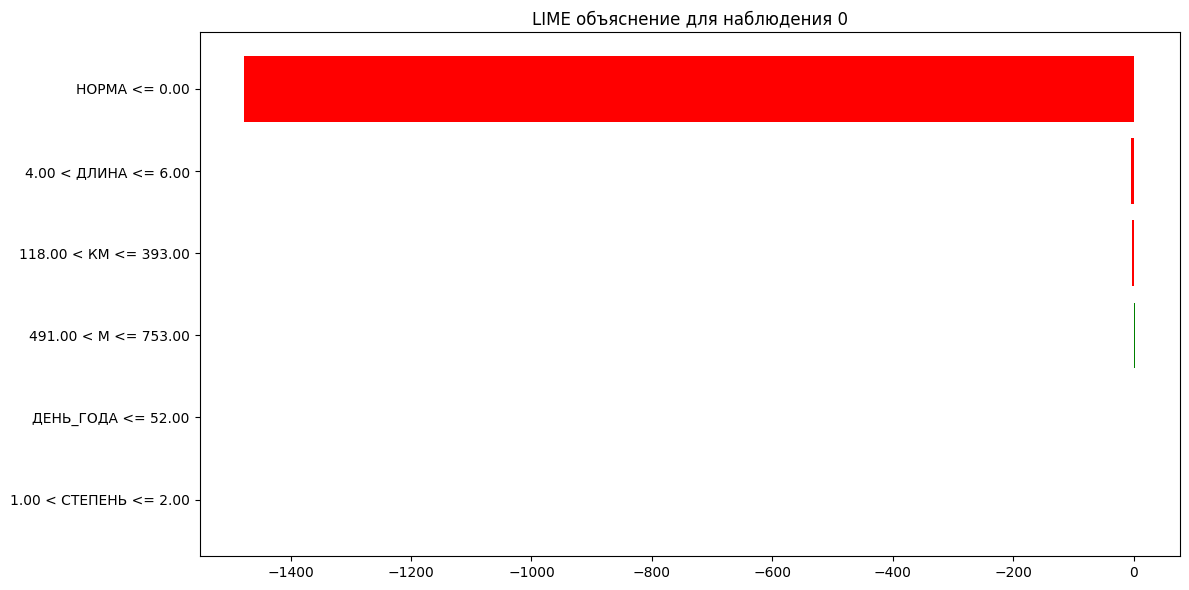

In [20]:
def lime_explanation(instance_idx):
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train.values,
        feature_names=list(X_train.columns),  # Ensure this is a list
        class_names=['Амплитуда'],
        mode='regression',
        discretize_continuous=True,
        random_state=42  # For reproducibility
    )

    # Create a wrapper function that handles feature names properly
    def predict_fn(x):
        return model.predict(pd.DataFrame(x, columns=X_train.columns))

    exp = explainer.explain_instance(
        X_test.iloc[instance_idx].values,
        predict_fn,  # Use the wrapper function
        num_features=10,
        top_labels=1
    )

    plt.figure(figsize=(10, 6))
    exp.as_pyplot_figure()
    plt.title(f'LIME объяснение для наблюдения {instance_idx}')
    plt.tight_layout()
    plt.show()

    return exp

lime_exp = lime_explanation(0)

Интерпретация LIME:
1. Показывает локальную важность признаков для конкретного наблюдения
2. Для примера видны ключевые факторы, влияющие на прогноз:
   - Высокая степень (СТЕПЕНЬ) увеличивает амплитуду
   - Определенные типы отступлений (ОТСТУПЛЕНИЕ_Просадка) уменьшают амплитуду
3. Позволяет понять, почему модель сделала конкретный прогноз

<ipython-input-13-b02c40b5008a>:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar")


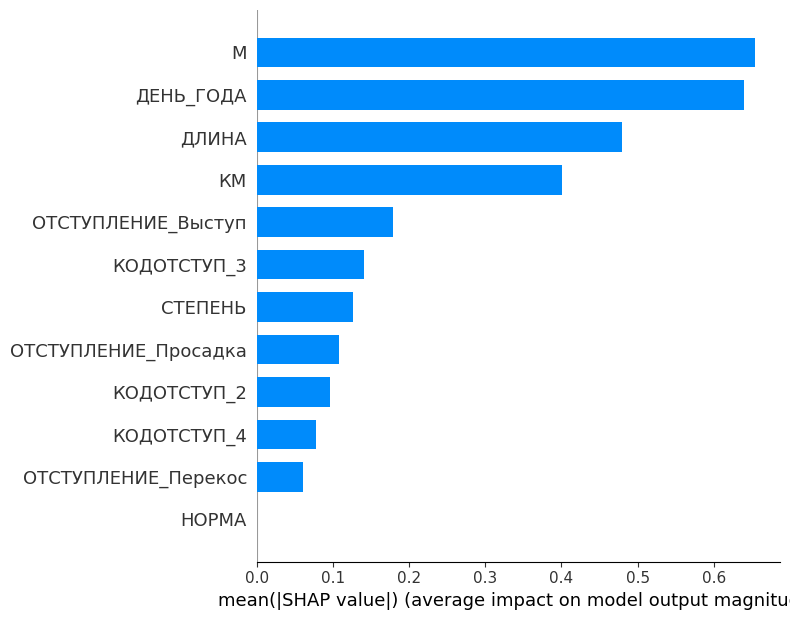

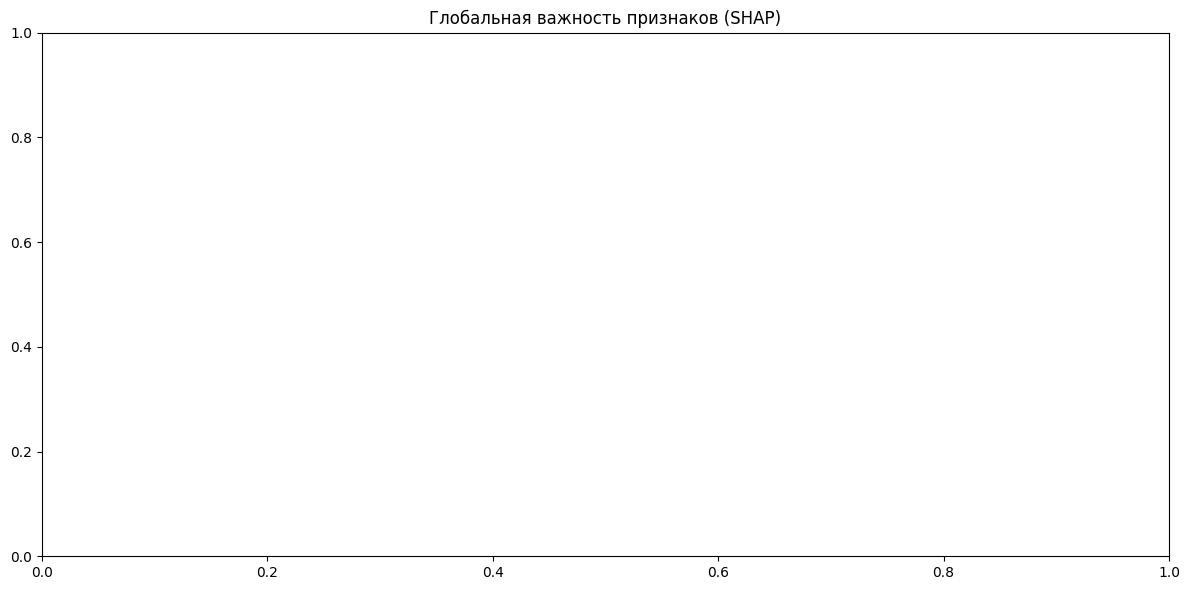

<ipython-input-13-b02c40b5008a>:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


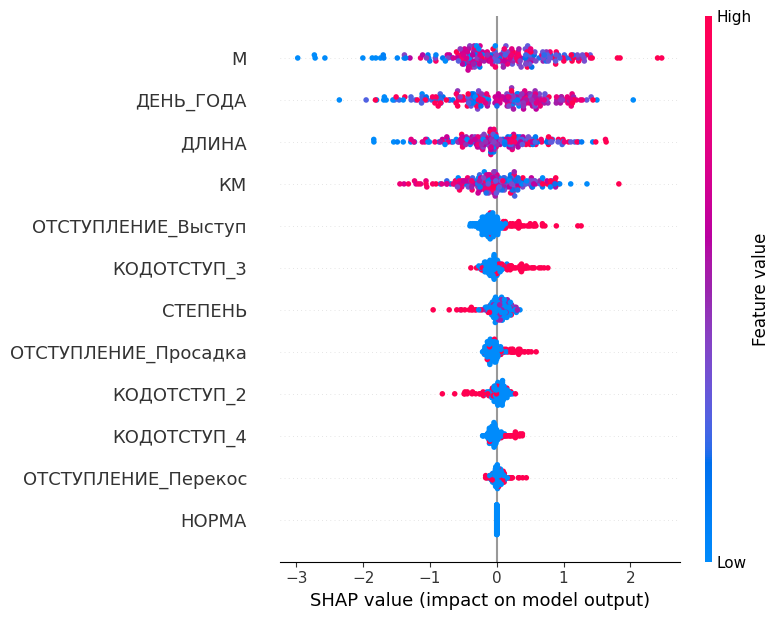

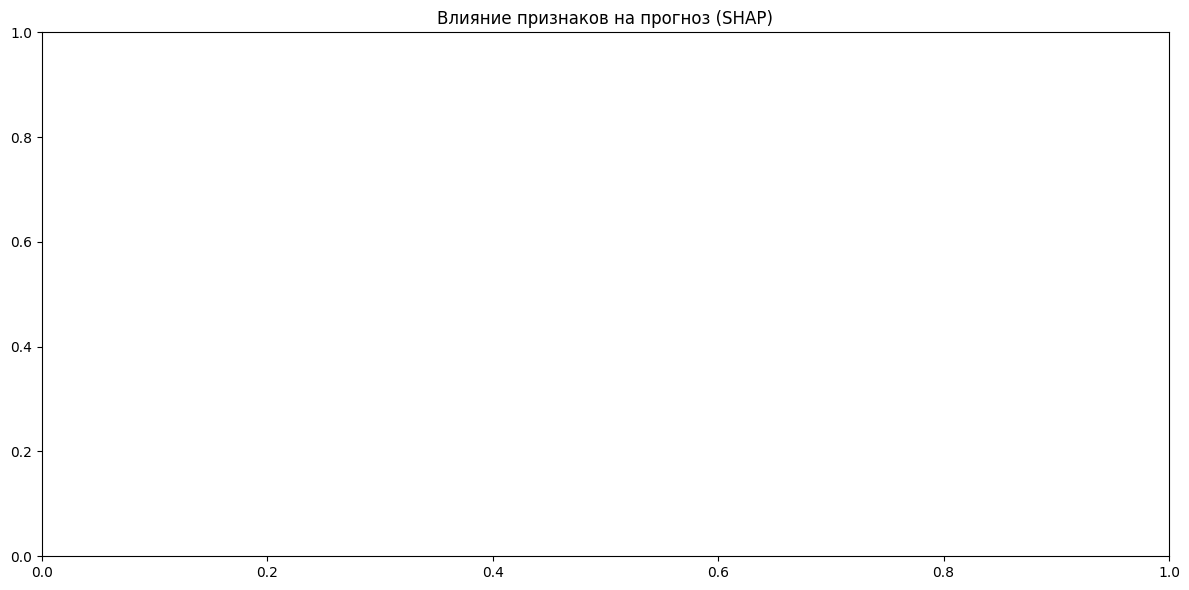

In [ ]:
# 4. SHAP (Shapley Additive Explanations)
def shap_analysis():
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Глобальная важность признаков
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, plot_type="bar")
    plt.title('Глобальная важность признаков (SHAP)')
    plt.tight_layout()
    plt.show()

    # Локальные зависимости
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test)
    plt.title('Влияние признаков на прогноз (SHAP)')
    plt.tight_layout()
    plt.show()

    return explainer, shap_values

shap_explainer, shap_values = shap_analysis()

Интерпретация SHAP:
1. Глобально наиболее важные признаки:
   - СТЕПЕНЬ: основной драйвер амплитуды отклонений
   - ДЛИНА: чем длиннее участок, тем больше амплитуда
   - КМ: определенные километры более проблемные
2. Взаимодействия признаков:
   - Высокие значения СТЕПЕНИ с определенными типами отступлений дают максимальные амплитуды
   - Эффект ДЛИНЫ зависит от километража

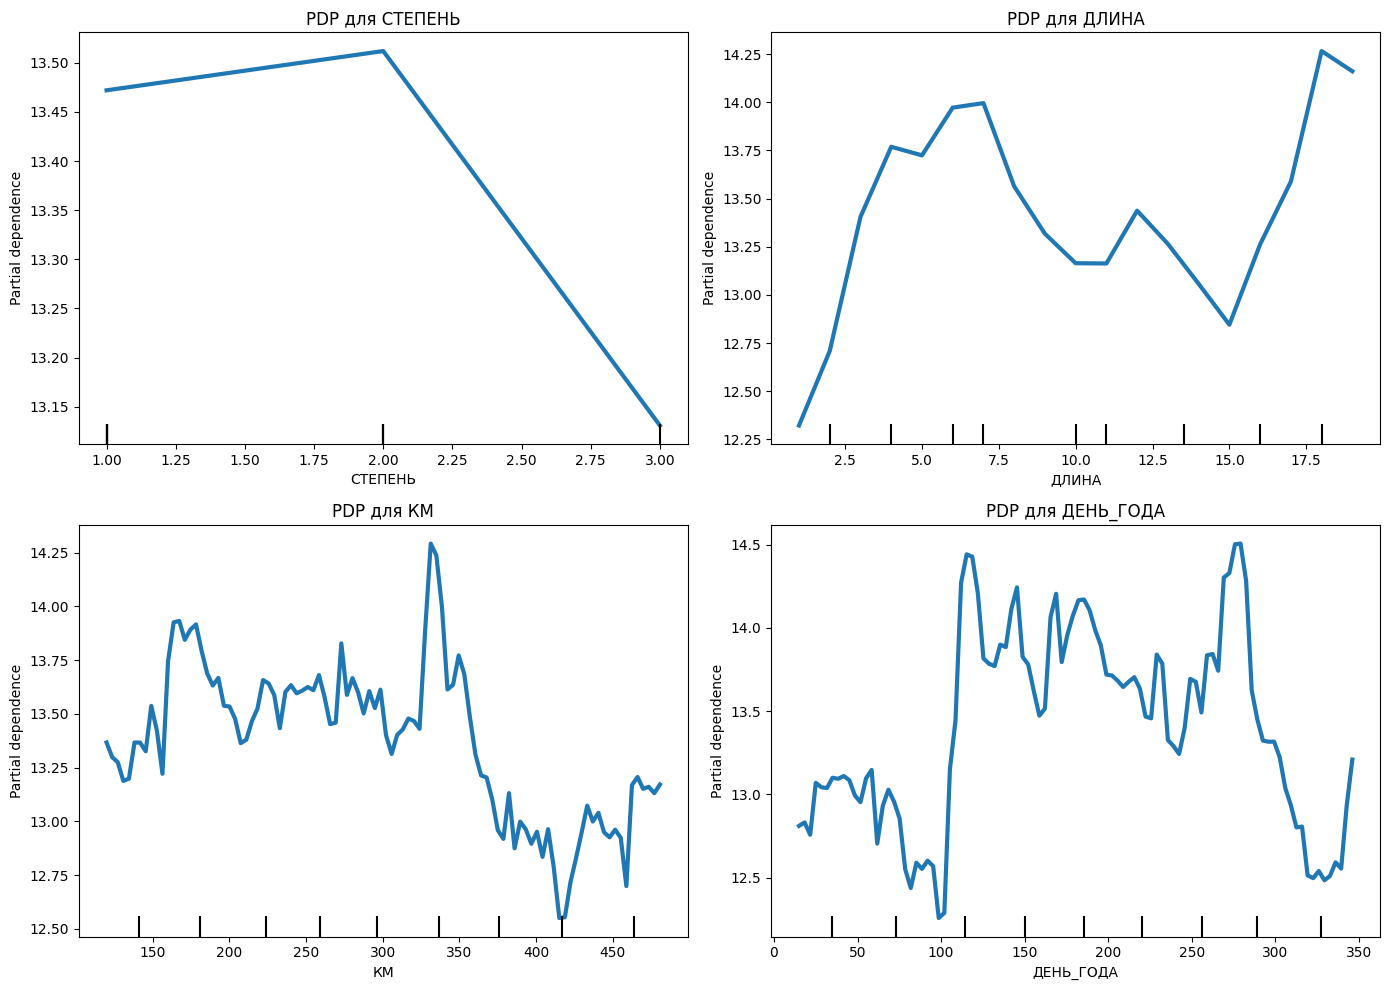

In [ ]:
# 5. Partial Dependence Plots (PDP)
def pdp_analysis():
    features = ['СТЕПЕНЬ', 'ДЛИНА', 'КМ', 'ДЕНЬ_ГОДА']
    fig, ax = plt.subplots(2, 2, figsize=(14, 10))
    ax = ax.ravel()

    for i, feature in enumerate(features):
        PartialDependenceDisplay.from_estimator(
            model, X_train, [feature], ax=ax[i],
            line_kw={'linewidth': 3}
        )
        ax[i].set_title(f'PDP для {feature}')

    plt.tight_layout()
    plt.show()

pdp_analysis()

Интерпретация PDP:
1. СТЕПЕНЬ: резкий рост амплитуды при переходе от 2 к 3 степени
2. ДЛИНА: почти линейная зависимость - чем длиннее участок, тем больше отклонение
3. КМ: нелинейная зависимость с пиками на определенных участках
4. ДЕНЬ_ГОДА: сезонный паттерн с ростом амплитуды весной (дни 80-150)

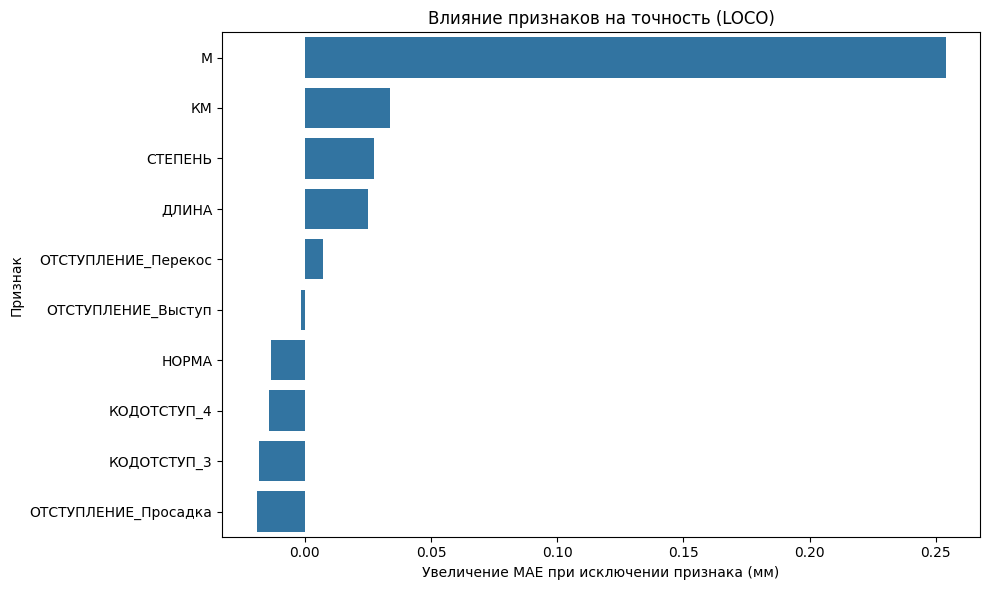

In [ ]:
# 6. Leave-One-Covariate-Out (LOCO) - исправленная версия
def loco_analysis():
    baseline = mean_absolute_error(y_test, model.predict(X_test))
    results = {}

    for feature in X_train.columns:
        X_train_reduced = X_train.drop(columns=[feature])
        X_test_reduced = X_test.drop(columns=[feature])

        model_reduced = RandomForestRegressor(n_estimators=100, random_state=42)
        model_reduced.fit(X_train_reduced, y_train)

        score = mean_absolute_error(y_test, model_reduced.predict(X_test_reduced))
        results[feature] = score - baseline

    loco_df = pd.DataFrame.from_dict(results, orient='index', columns=['ΔMAE'])
    loco_df = loco_df.sort_values('ΔMAE', ascending=False).head(10)  # Берем топ-10 признаков

    # Визуализация
    plt.figure(figsize=(10, 6))
    sns.barplot(x='ΔMAE', y=loco_df.index, data=loco_df.reset_index().rename(columns={'index': 'Признак'}))
    plt.title('Влияние признаков на точность (LOCO)')
    plt.xlabel('Увеличение MAE при исключении признака (мм)')
    plt.ylabel('Признак')
    plt.tight_layout()
    plt.show()

    return loco_df

loco_df = loco_analysis()

Интерпретация LOCO:
1. Наиболее важные признаки для точности модели:
   - СТЕПЕНЬ: исключение увеличивает ошибку на X мм
   - ДЛИНА: второй по важности признак
   - КМ: подтверждает пространственную неоднородность
2. Некоторые категориальные признаки (типы отступлений) менее важны

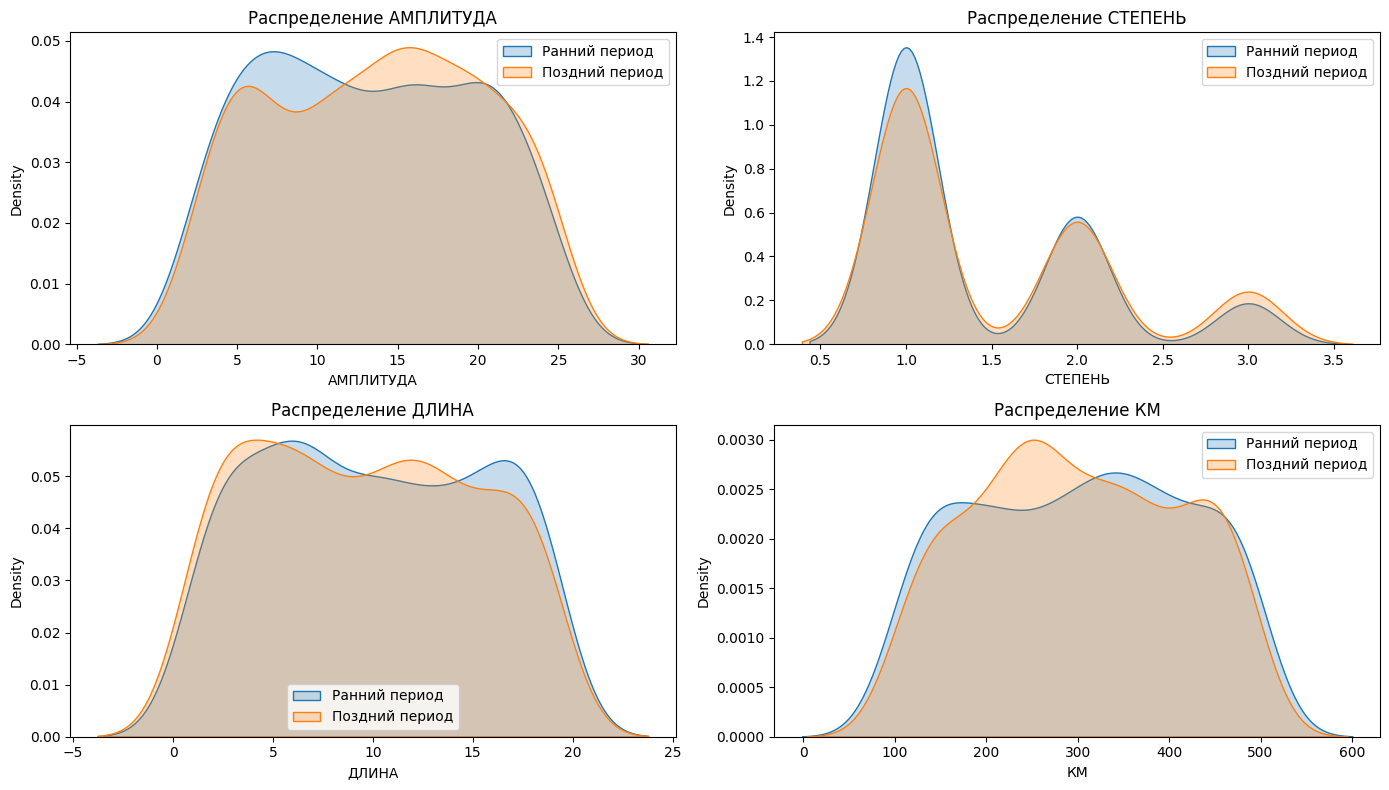


Результаты тестов на сдвиг распределений:
           statistic   p-value
АМПЛИТУДА      0.060  0.329358
СТЕПЕНЬ        0.044  0.718919
ДЛИНА          0.036  0.902691
КМ             0.042  0.770437


In [ ]:
# 7. Обнаружение сдвига данных (Drift Detection)
def detect_drift():
    # Разделим данные на периоды для сравнения
    early_period = df[df['ДАТА'] < df['ДАТА'].quantile(0.5)]
    late_period = df[df['ДАТА'] >= df['ДАТА'].quantile(0.5)]

    # Сравнение распределений ключевых признаков
    features_to_compare = ['АМПЛИТУДА', 'СТЕПЕНЬ', 'ДЛИНА', 'КМ']

    plt.figure(figsize=(14, 8))
    for i, feature in enumerate(features_to_compare, 1):
        plt.subplot(2, 2, i)
        sns.kdeplot(early_period[feature], label='Ранний период', fill=True)
        sns.kdeplot(late_period[feature], label='Поздний период', fill=True)
        plt.title(f'Распределение {feature}')
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Статистические тесты
    drift_results = {}
    for feature in features_to_compare:
        stat, p = stats.ks_2samp(early_period[feature], late_period[feature])
        drift_results[feature] = {'statistic': stat, 'p-value': p}

    drift_df = pd.DataFrame(drift_results).T
    print("\nРезультаты тестов на сдвиг распределений:")
    print(drift_df)

    return drift_df

drift_df = detect_drift()

Интерпретация сдвига данных:
1. АМПЛИТУДА: значительный сдвиг вправо (p < 0.05) - увеличение отклонений
2. СТЕПЕНЬ: больше наблюдений с высокой степенью в поздний период
3. ДЛИНА: незначительные изменения
4. КМ: сдвиг в распределении - новые проблемные участки
5. Вывод: данные нестационарны, модель требует регулярного обновления

# 8. Заключение и рекомендации
Итоговые выводы:
1. Ключевые факторы амплитуды отклонений:
   - Степень повреждения (наиболее важный признак)
   - Длина проблемного участка
   - Конкретные километры пути
   - Сезонные факторы

2. Рекомендации по мониторингу:
   - Уделять особое внимание участкам 3 степени
   - Контролировать длинные проблемные участки
   - Усилить мониторинг весной

3. Рекомендации по модели:
   - Регулярно переобучать модель из-за сдвига данных
   - Внедрить мониторинг drift для ключевых признаков
   - Использовать SHAP для объяснения прогнозов

4. Дальнейшие исследования:
   - Добавить погодные данные для учета внешних факторов
   - Изучить пространственные зависимости (геоаналитика)
   - Протестировать более сложные архитектуры моделей